# Chapter 11-6. Packed Sequence

길이가 각각 다른 sequence data를 하나로 묶는 방법 두 개 소개 (padding/packing)

https://pytorch.org/docs/stable/nn.html#packedsequence

- Examples of Sequential data
- How do we make a batch with multiple sequence sizes?
    - Padding Method
    - Packing Method
- PyTorch Library Functions
    - pad_sequence
    - pack_sequence
    - pad_packed_sequence
    - pack_padded_sequence

---

## Sequential data
- DNA, video 등..
- 자연어 처리(NLP)에서 많이 쓰이는 text data
- audio data: 시간과 sampling data에 따라 audio data 길이가 달라지게 됨

- 이와 같이 sequence data들을 **길이가 미정**인 data가 많음
    - 반면, sequence data가 아닌 image인 경우는 fixed size Tensor 가지게 됨

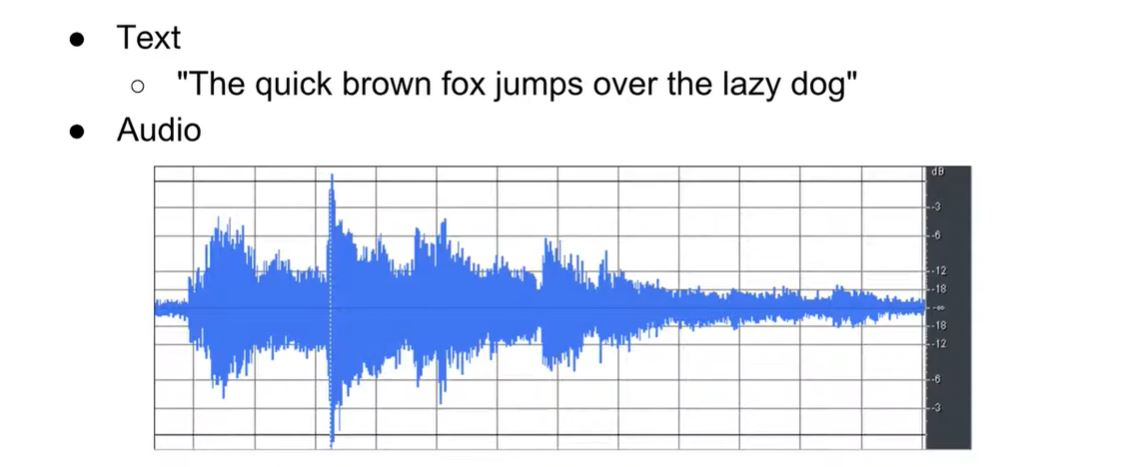

---

## Padding & Packing Methods

text sequence data - 어떻게 하면 하나의 batch로?

### Padding

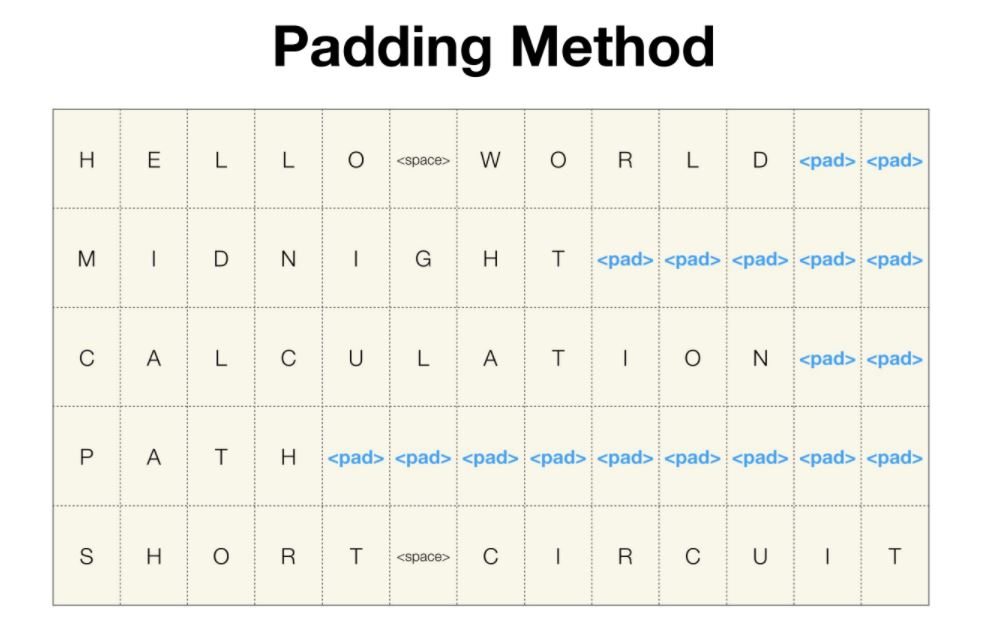

가장 긴 sequence의 길이에 맞춰(short circuit) 나머지 data 뒷 부분을 *pad라는 token* 써서 채워 넣음

- data가 깔끔하게 됨: (batch_size * 가장 긴 sequence 길이) -> 하나의 Tensor 로
    - 컴퓨터 처리 용이
- 단점: 계산하지 않아도 될 뒷부분 계산하게 됨

### Packing

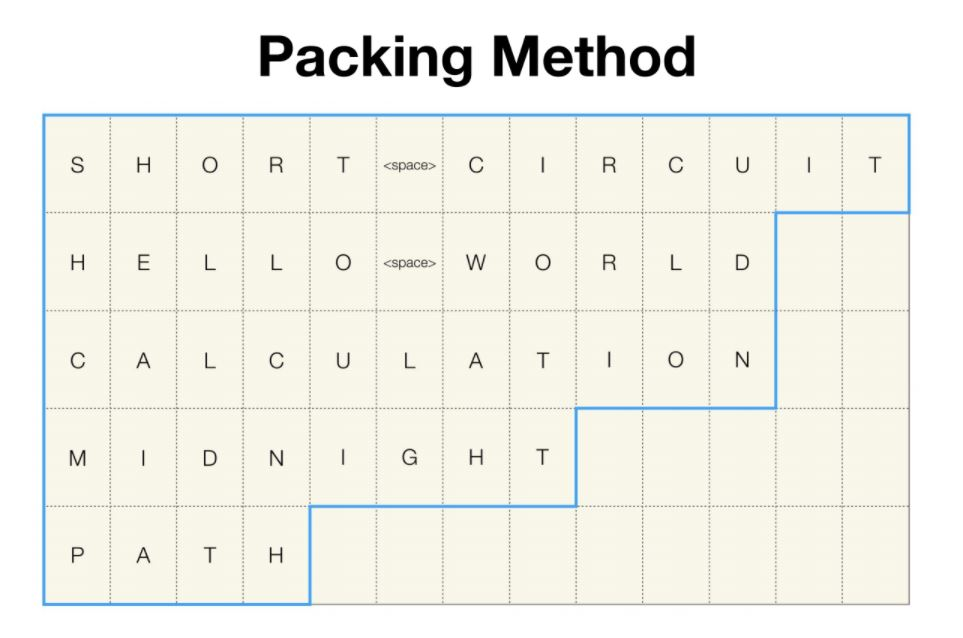

Sequence 길이에 대한 정보를 저장하고 있는 방식으로 진행
- Pad Token X
- 제대로 동작하려면: batch data가 길이 내림차순으로 정렬되어야 함
    - sequence 대한 정보 + 실제 data Tensor 같이 가지고 있는 자료 구조를 *pack_sequence*라고 함.
- 장점: 효율적 (padding에 비해), Pad Token 쓰지 않아도 됨
- 단점: 내림차순으로 정렬을 해 줘야 함, 구현 시 padding에 비해 조금 더 복잡함

---

### Library Function

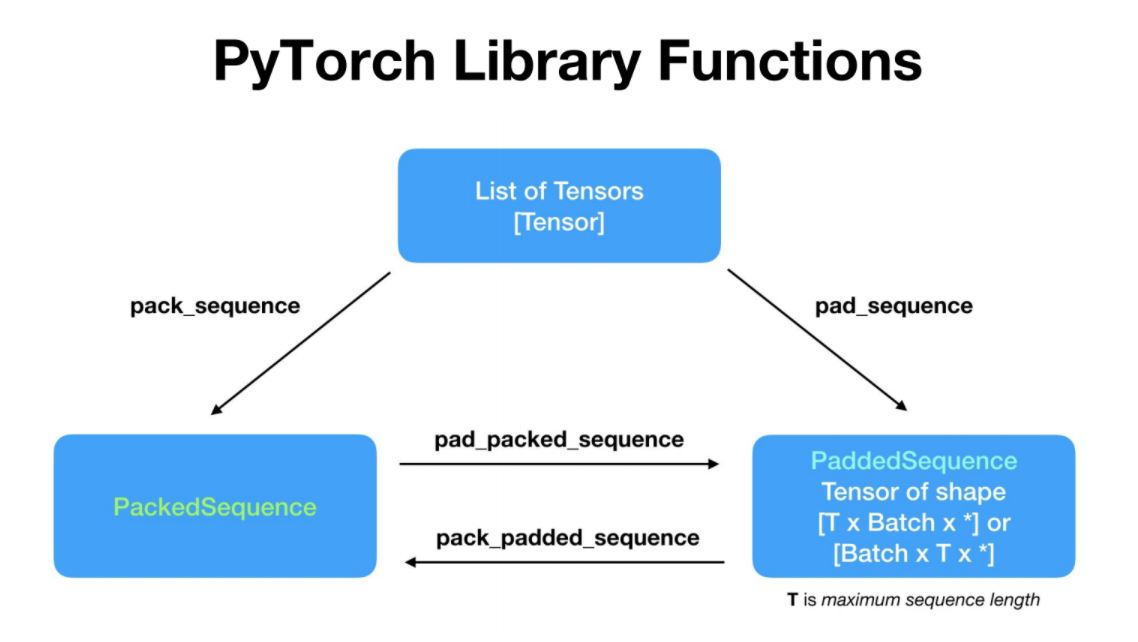

*PackedSequence*: 기본적인 packing 

*PaddedSequence*: padding을 적용한 tensor

- padding이 된 것을 pack_sequence로 바꾸고 싶으면: pack_padded_sequence 함수 이용
- packing이 된 pack_sequence를 padding이 된 Tensor로 바꾸고 싶으면: pad_packed_sequence 함수 이용

---

## Code & Ex

In [1]:
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence, pad_packed_sequence

예제 데이터 - batch size is 5, max sequence is 13

In [2]:
# Random word from random word generator
data = ['hello world',
        'midnight',
        'calculation',
        'path',
        'short circuit']

# Make dictionary
char_set = ['<pad>'] + list(set(char for seq in data for char in seq)) # Get all characters and include pad token
char2idx = {char: idx for idx, char in enumerate(char_set)} # Constuct character to index dictionary
print('char_set:', char_set)
print('char_set length:', len(char_set))

char_set: ['<pad>', 'a', 'e', 't', 'w', 'h', 'd', 'p', 'r', 'm', 'c', 'u', 'n', 'l', 's', 'o', 'g', 'i', ' ']
char_set length: 19


In [3]:
# Convert character to index and make list of tensors
X = [torch.LongTensor([char2idx[char] for char in seq]) for seq in data]

# Check converted result
for sequence in X:
    print(sequence)

tensor([ 5,  2, 13, 13, 15, 18,  4, 15,  8, 13,  6])
tensor([ 9, 17,  6, 12, 17, 16,  5,  3])
tensor([10,  1, 13, 10, 11, 13,  1,  3, 17, 15, 12])
tensor([7, 1, 3, 5])
tensor([14,  5, 15,  8,  3, 18, 10, 17,  8, 10, 11, 17,  3])


In [4]:
# Make length tensor (will be used later in 'pack_padded_sequence' function)
lengths = [len(seq) for seq in X]
print('lengths:', lengths)

lengths: [11, 8, 11, 4, 13]


sequence 길이 모두 다름 - *Padding 사용*

cf. pytorch에서는 **PackedSequence** 쓰면 padding 없이 정확히 필요한 부분까지 병렬 계산 가능

### pad_sequence 사용 PaddedSequence 만들기

PaddedSequence: sequence 길이를 모두 맞춰 주기 위해 padding 추가한 일반적 tensor
- 따로 class 존재 X
- pad_sequence library로 padding 추가 가능
- input: Tensor들의 *list*
- padding_value=42처럼 파라미터 지정해 주면 padding 값 지정 가능

In [5]:
# Make a Tensor of shape (Batch x Maximum_Sequence_Length)
padded_sequence = pad_sequence(X, batch_first=True) # X is now padded sequence
print(padded_sequence)
print(padded_sequence.shape)

tensor([[ 5,  2, 13, 13, 15, 18,  4, 15,  8, 13,  6,  0,  0],
        [ 9, 17,  6, 12, 17, 16,  5,  3,  0,  0,  0,  0,  0],
        [10,  1, 13, 10, 11, 13,  1,  3, 17, 15, 12,  0,  0],
        [ 7,  1,  3,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [14,  5, 15,  8,  3, 18, 10, 17,  8, 10, 11, 17,  3]])
torch.Size([5, 13])


### pack_sequence 사용 PackedSequence 만들기

PackedSequence: padding 추가 X 주어진 sequence 길이까지만 모델이 연산 가능하도록 하는 pytorch의 DS
- 주어진 input: list of Tensor, **내림차순 정렬**되어 있어야 함

In [6]:
# Sort by descending lengths
sorted_idx = sorted(range(len(lengths)), key=lengths.__getitem__, reverse=True)
sorted_X = [X[idx] for idx in sorted_idx]

# Check converted result
for sequence in sorted_X:
    print(sequence)

tensor([14,  5, 15,  8,  3, 18, 10, 17,  8, 10, 11, 17,  3])
tensor([ 5,  2, 13, 13, 15, 18,  4, 15,  8, 13,  6])
tensor([10,  1, 13, 10, 11, 13,  1,  3, 17, 15, 12])
tensor([ 9, 17,  6, 12, 17, 16,  5,  3])
tensor([7, 1, 3, 5])


내림차순으로 정렬함 → ```pack_sequence``` 사용하여 PackedSequence 제작

In [7]:
packed_sequence = pack_sequence(sorted_X)
print(packed_sequence)

PackedSequence(data=tensor([14,  5, 10,  9,  7,  5,  2,  1, 17,  1, 15, 13, 13,  6,  3,  8, 13, 10,
        12,  5,  3, 15, 11, 17, 18, 18, 13, 16, 10,  4,  1,  5, 17, 15,  3,  3,
         8,  8, 17, 10, 13, 15, 11,  6, 12, 17,  3]), batch_sizes=tensor([5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 1, 1]), sorted_indices=None, unsorted_indices=None)


### Embedding 적용

PackedSequence, PaddedSequence 제작됨 → RNN에 input으로 넣기
- character index 지닌 data를 embedding 한 값을 RNN의 input으로 넣음
- one hot chararcter embedding 수행

In [8]:
# one-hot embedding using PaddedSequence
eye = torch.eye(len(char_set)) # Identity matrix of shape (len(char_set), len(char_set))
embedded_tensor = eye[padded_sequence]
print(embedded_tensor.shape) # shape: (Batch_size, max_sequence_length, number_of_input_tokens)

torch.Size([5, 13, 19])


In [16]:
# one-hot embedding using PackedSequence
embedded_packed_seq = pack_sequence([eye[X[idx]] for idx in sorted_idx])
print(embedded_packed_seq.data.shape)

torch.Size([47, 19])


### RNN 모델 제작

In [17]:
# declare RNN
rnn = torch.nn.RNN(input_size=len(char_set), hidden_size=30, batch_first=True)

```PaddedSeqence``` 이용

In [18]:
rnn_output, hidden = rnn(embedded_tensor)
print(rnn_output.shape) # shape: (batch_size, max_seq_length, hidden_size)
print(hidden.shape)     # shape: (num_layers * num_directions, batch_size, hidden_size)

torch.Size([5, 13, 30])
torch.Size([1, 5, 30])


```PackedSequence``` 이용

In [19]:
rnn_output, hidden = rnn(embedded_packed_seq)
print(rnn_output.data.shape)
print(hidden.data.shape)

torch.Size([47, 30])
torch.Size([1, 5, 30])


### pad_packed_sequence
PackedSequence -> PaddedSequence(Tensor) 함수

- PackedSequence: sequence length 정보 보유
    - tensor + 길이에 대한 리스트 -> 튜플로 리턴

In [20]:
unpacked_sequence, seq_lengths = pad_packed_sequence(embedded_packed_seq, batch_first=True)
print(unpacked_sequence.shape)
print(seq_lengths)

torch.Size([5, 13, 19])
tensor([13, 11, 11,  8,  4])


## pack_padded_sequence
PaddenSequence(Tensor with Padding) -> PackedSequence

- pack_padded_sequence: 실제 sequence 길이에 대한 정보 모름
    - parameter로 제공 필수
- input: PaddedSequence
    - 길이에 따른 내림차순으로 정렬되어 있어야 함

padded_sequence 변수 내림차순으로 정렬되도록 새로 제작

In [21]:
embedded_padded_sequence = eye[pad_sequence(sorted_X, batch_first=True)]
print(embedded_padded_sequence.shape)

torch.Size([5, 13, 19])


padding 된 Tensor를 PackedSequence로 변환

In [22]:
sorted_lengths = sorted(lengths, reverse=True)
new_packed_sequence = pack_padded_sequence(embedded_padded_sequence, sorted_lengths, batch_first=True)
print(new_packed_sequence.data.shape)
print(new_packed_sequence.batch_sizes)

torch.Size([47, 19])
tensor([5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 1, 1])
